## Lecture Content
- Earthquake prediction background & helpful resources
- Step 1 - Installing dependencies
- Step 2 - Importing dataset
- Step 3 - Exploratory data analysis
- Step 4 - Feature engineering (statistical features added)
- Step 5 - Implement "Catboost" model
- Step 6 - Implement Support Vector Machine + Radial Basis Function model
- Step 7 - Future Directions (Genetic Programming, Recurrent Networks, etc.)
- Step 8 - Freestyle Rap


## EarthQuake Prediction Background

- Predicting earthquakes has long been thought to be near-impossible. 
- Being able to predict earthquakes could allow us to better protect human life and property.

![alt text](https://i.imgur.com/rTadNbm.png)

- There are many ways to compute the magnitude of an earthquake!
- A0 is the seismometer reading produced by an Earthquake of standard size (i.e., a calibration earthquake). Generally A0 is 0.001 mm. 
- This equation assumes that a distance of 100 km separates the seismometer and the epicentre
![alt text](http://1.bp.blogspot.com/-wX1aS8tcJ6U/Tby9LlQkLiI/AAAAAAAAAZI/zA16efEl_qc/s200/Picture1.png)
![alt text](http://exponential-logarithm-project.weebly.com/uploads/6/5/6/0/65601499/8320544.png?1447690096)
![alt text](https://geology.com/records/largest-earthquake/global-seismic-moment-release.gif)
![alt text](https://www.sott.net/image/s15/315072/full/ryzproductionsfuture_blogspot_.jpg)




- Given seismic signals we are asked to predict the time until the onset of laboratory earthquakes 
- In the lab, 2 plates are put under pressure, resulting in shear stress
- The training data is a single sequence of signal and seems to come from one experiment alone.
- The test data consists of several different sequences, called segments, that may correspond to different experiments. 
- For each test data segment with its corresponding seg_id we are asked to predict it's single time until the lab earthquake takes place.

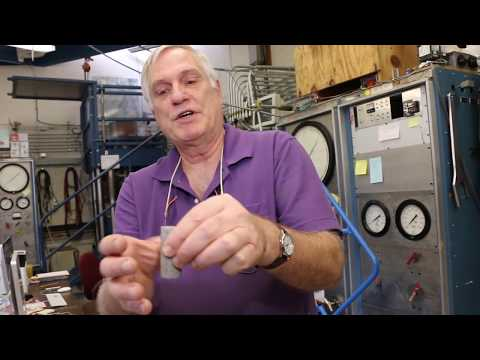

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('m_dBwwDJ4uo')



## Before we begin, check out these helpful resources

- https://www.kaggle.com/kernels  (For Ideas)
- https://paperswithcode.com (For the latest ML models)

# Step 1 - Install & Import Dependencies

In [6]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy==1.15.0
#Machine learning
!pip install catboost

    100% |████████████████████████████████| 55.5MB 657kB/s 


In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

# Step 2 - Import Dataset from Kaggle

In [3]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [4]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2625           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9896           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4145           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2287           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897           False  
LANL-Ear

In [5]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.0MB/s]
 95% 231M/242M [00:01<00:00, 148MB/s]
100% 242M/242M [00:01<00:00, 159MB/s]
100% 2.02G/2.03G [00:36<00:00, 24.4MB/s]
100% 2.03G/2.03G [00:36<00:00, 59.9MB/s]


In [7]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip train.csv.zip
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


# Step 3 - Exploratory Data Analysis

In [0]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [24]:
#print first 10 entries
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


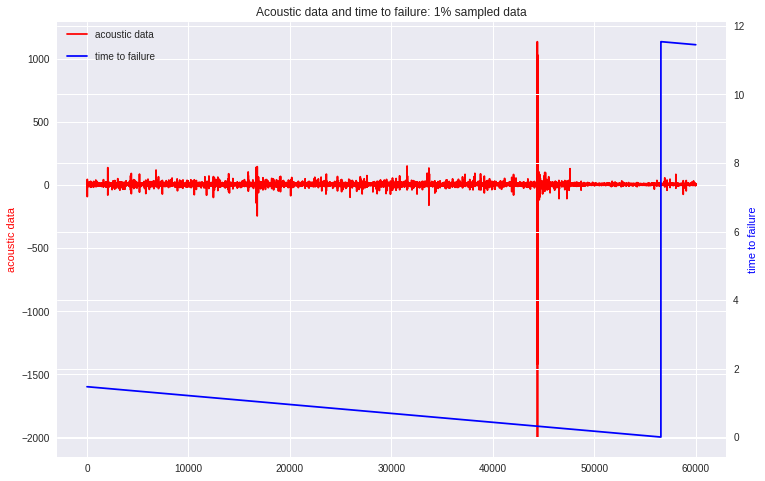

In [41]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

![alt text](https://www.kaggleusercontent.com/kf/10364757/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..onsybg1U7xvMy-GjJdYtTA.RUVJoAZ7sxCnRNmM1WTjXMjmsl7raHI_FzIYc0vh0poV3hcKVMrr2GRPCwlr_urWqByjmahePNQlEFEsBBUO2meVZXzX-HjRQuU40ySqElezoc9HLF7nGBMCKPSYt-HPZAsGHnXBtkXV8qVOZlu5BWddQp7wthNJ5JkSftT41GM.vS5mBigypyc7eNri4zC2rQ/__results___files/__results___12_0.png)

#### Also, shoutout to Anton Loss. He turned this data into sound, then compared it with dubstep.

[Anton's work here](https://www.kaggle.com/avloss/audio-analysis-with-animation)

#####  Anton's hypothesis: perhaps just like a dubstep song, we can hear the build-up of an earthquake before the drop
1. The data looks like sound waves, it oscillates! Thus, he converted it into an audio file.
2. He then denoised the audio file
3. Next, he animated the wave
4. Finally, he compared it to a dubstep song


In [63]:
%%HTML
<video width="320" height="240" controls>
  <source src="https://www.kaggleusercontent.com/kf/10317300/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..i3D--jDnUYfbn8vMyX3RVg.wV-Ek57ve9b_f8UthEd5YAE5rqBUgeMkXYmWJqcoaJgldO5d7afEsXTYoyC395ZJcMiXqrqeuxoaStyStAQLJFGH0KtzE-4sGt41imaqW5Y9tcu7XH8UqCgDlrUjWlK_PqM1akZHI9nohY3UNahoMN_2Z4u1ORWZ3u1iLtQv9jk.Cyv4iN3TfPCuUP5G7v47Bw/animation_with_sound.mp4" type="video/mp4">
</video>

<video width="320" height="240" controls>
  <source src="https://www.kaggleusercontent.com/kf/10317300/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..i3D--jDnUYfbn8vMyX3RVg.wV-Ek57ve9b_f8UthEd5YAE5rqBUgeMkXYmWJqcoaJgldO5d7afEsXTYoyC395ZJcMiXqrqeuxoaStyStAQLJFGH0KtzE-4sGt41imaqW5Y9tcu7XH8UqCgDlrUjWlK_PqM1akZHI9nohY3UNahoMN_2Z4u1ORWZ3u1iLtQv9jk.Cyv4iN3TfPCuUP5G7v47Bw/animation_with_dubstep.mp4" type="video/mp4">
</video>

# Step 4 - Feature Engineering

In [0]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)



![alt text](https://qph.fs.quoracdn.net/main-qimg-29a4925034e075f16e1c743a4b3dda8b)
![alt text](https://qph.fs.quoracdn.net/main-qimg-cb5a6703bdfd5e2a15cf8865607a1590)
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTkRGxxt76XIth4pjG5Itp-k6MNt5qPaejI_gyENu17KkGC2oFq)
![alt text](https://cramster-image.s3.amazonaws.com/definitions/DC-2195V1.png)
![alt text](https://i.stack.imgur.com/KBQLN.jpg)
- Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 
- Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers
![alt text](https://study.com/cimages/multimages/16/skewness_posnegpict.jpg)
- skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined.
![alt text](https://upload.wikimedia.org/wikipedia/commons/5/5e/Iqr_with_quantile.png)
- Quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way. 


![alt text](https://www.researchgate.net/publication/304403489/figure/fig4/AS:427142036103170@1478850005427/Statistical-features.png
)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


In [64]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,3.482899,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,1.621138,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,2.199321,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,2.820130,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,3.324506,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,3.805475,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,31.724966,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


# Step 5 - Implement Catboost Model

- Yandex is Russian Google
- Yandex uses "gradient boosting" a lot to power their services (music streaming, search, everything really)
- Gradient boosting on decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions. 
- It's particularly useful for predictive models that analyze ordered (continuous) data and categorical data. 
- It's  one of the most efficient ways to build ensemble models. The combination of gradient boosting with decision trees provides state-of-the-art results in many applications with structured data.
- On the first iteration, the algorithm learns the first tree to reduce the training error, shown on left-hand image in figure 1. 
- This model usually has a significant error; it’s not a good idea to build very big trees in boosting since they overfit the data.
- The right-hand image in figure 1 shows the second iteration, in which the algorithm learns one more tree to reduce the error made by the first tree. 
- The algorithm repeats this procedure until it builds a decent quality model

![alt text](https://devblogs.nvidia.com/wp-content/uploads/2018/12/first-second-trees-625x357.png)


- Gradient Boosting is a way to implement this idea for any continuous objective function. 

### Each step of Gradient Boosting combines two steps:

- Step 1 - Computing gradients of the loss function we want to optimize for each input object
- Step 2 - Learning the decision tree which predicts gradients of the loss function

### ELI5 Time

- Step 1 - We first model data with simple models and analyze data for errors. 
- Step 2 - These errors signify data points that are difficult to fit by a simple model. 
- Step 3 - Then for later models, we particularly focus on those hard to fit data to get them right. 
- Step 4 -  In the end, we combine all the predictors by giving some weights to each predictor.


In [54]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.74357544138688}}

# Step 6 - Implement Support Vector Machine + Radial Basis Function Kernel 

you might be thinking WTF YOOOOoooo. thats ok, breathe. here we go. 

### Need to learn a nonlinear decision boundary? Grab a Kernel

- A very simple and intuitive way of thinking about kernels (at least for SVMs) is a similarity function. 
- Given two objects, the kernel outputs some similarity score. The objects can be anything starting from two integers, two real valued vectors, trees whatever provided that the kernel function knows how to compare them.

- The arguably simplest example is the linear kernel, also called dot-product. Given two vectors, the similarity is the length of the projection of one vector on another.

- Another interesting kernel examples is Gaussian kernel. Given two vectors, the similarity will diminish with the radius of σ. The distance between two objects is "reweighted" by this radius parameter.

- The success of learning with kernels (again, at least for SVMs), very strongly depends on the choice of kernel. You can see a kernel as a compact representation of the knowledge about your classification problem. It is very often problem specific.

![alt text](https://i.stack.imgur.com/FsYi6.png)
![alt text](http://www.statsoft.com/textbook/graphics/SVMIntro3.gif)
![alt text](https://slideplayer.com/slide/3397099/12/images/26/Support+vector+machines.jpg)
![alt text](https://i.stack.imgur.com/rZyn7.png)
![alt text](https://slideplayer.com/slide/5745650/19/images/95/Support+Vector+Machines.jpg)
![alt text](https://image.slidesharecdn.com/svm-140807035301-phpapp01/95/support-vector-machine-without-tears-5-638.jpg?cb=1407384107)

## grid search : pick a bunch of values of α -- (α1,α2,…), pick a bunch of values of β -- (β1,β2,…) and for each pair of values, evaluate the validation error function. Then pick the pair that gives the minimum value of the validation error function.

The pairs (α1,β1),(α1,β2),…,(α2,β1),(α2,β2),… when plotted in space look like a grid, hence the name.

In [56]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1651
{'C': 2, 'gamma': 0.02}


# Future Ideas 
- Recurrent Networks
- Genetic Algorithms
- Ordinary Differential Equation Networks (YOOOOOO)

## Time to Rap